In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import rcParams
import dill
import copy
from figaro.utils import recursive_grid
from figaro.credible_regions import ConfidenceArea
from figaro.marginal import marginalise as marg_figaro
from figaro.load import load_density
from figaro.plot import plot_median_cr

from pathlib import Path
from tqdm import tqdm
from corner import corner
from scipy.interpolate import RegularGridInterpolator
import time 
from lensingpop.utils.utils import *


npt = 150
n_pts  = np.array([npt,npt])
z_bds  = [0.02,1.3]
m1_bds = [5, 220]
q_bds  = [0.1, 1.0]#[5.,240.]
bounds = np.array([m1_bds, q_bds])
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


In [2]:
data = np.load('./catalog/m1zq_posterior_afterSelection_unlensed1519.npz')

m1z=data['m1z']
q=data['q']
m1 = m1z / (1 + redshift)

m1z_posterior = data['m1z_posterior']
q_posterior = data['q_posterior']

In [17]:

sys.path.append(homedir+ 'population')
from benchmark import *
file = './prior/population_models/benchmark_obs_m1z_kde.pkl' # Change for specific paths
with open(file, 'rb') as f:
    bench = dill.load(f)

file = './prior/population_models/benchmark_obs_q_kde.pkl' # Change for specific paths
with open(file, 'rb') as f:
    bench_q = dill.load(f)
    

file = './prior/population_models/powerlaw_m1zq.pkl' # Change for specific paths
with open(file, 'rb') as f:
    pl = dill.load(f)
    
    
file = './prior/population_models/powerlaw_m1z.pkl' # Change for specific paths
with open(file, 'rb') as f:
    pl_m1z = dill.load(f)
    
    
file = './prior/population_models/powerlaw_q.pkl' # Change for specific paths
with open(file, 'rb') as f:
    pl_q = dill.load(f)


file = './prior/population_models/uni_m1z.pkl' # Change for specific paths
with open(file, 'rb') as f:
    uni_m1z = dill.load(f)
    
    
file = './prior/population_models/uni_q.pkl' # Change for specific paths
with open(file, 'rb') as f:
    uni_q = dill.load(f)


hier = load_density('./prior/population_models/draws_observed_figaro.json')

In [13]:
from figaro.marginal import marginalise

def percen(probs, dx, percentiles = [50, 5, 16, 84, 95]):
    p = {}
    for perc in percentiles:
        p[perc] = np.percentile(probs, perc, axis = 0)

    norm = p[50].sum()*dx
    for perc in percentiles:
        p[perc] = p[perc]/norm
    return p


100%|██████████| 100/100 [00:00<00:00, 9391.42it/s]


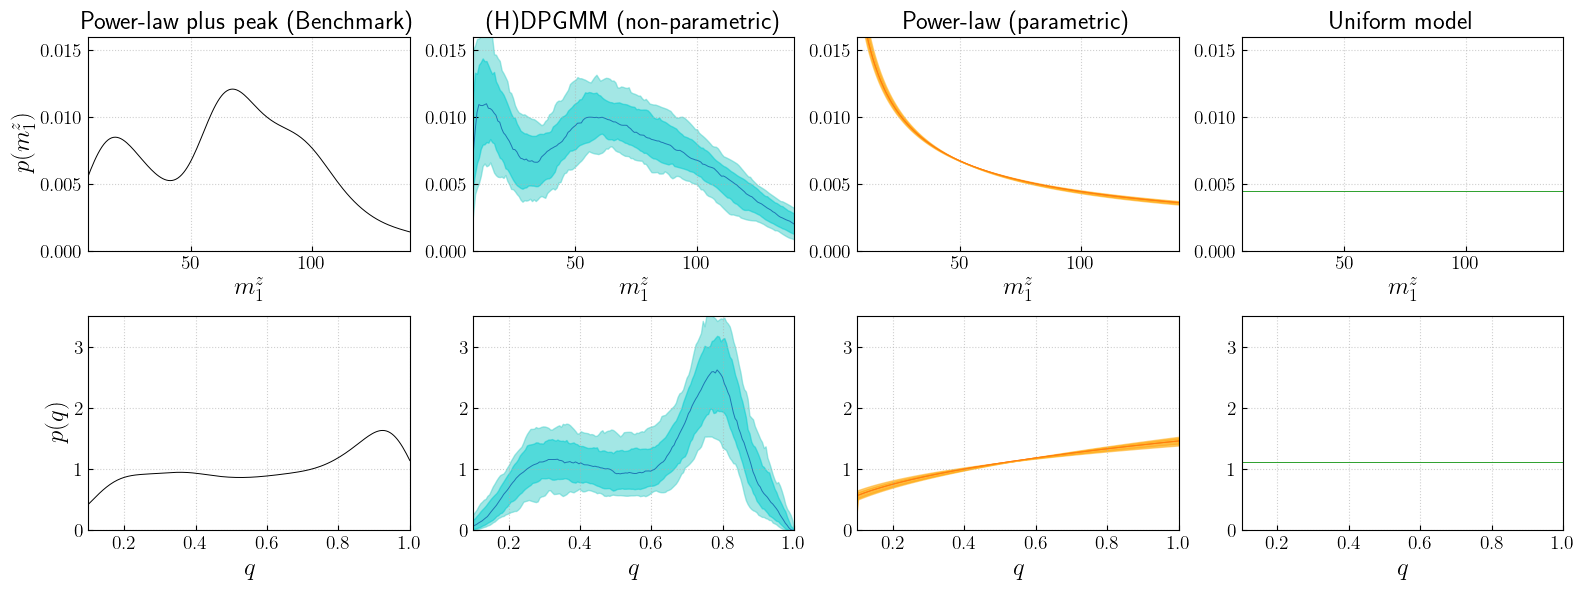

In [31]:
fig, axs = plt.subplots(nrows=2, ncols=4,figsize=(16,6))
 
    
i = 0 
x  = np.linspace(5, 160, 200)

p = bench.pdf(x)
axs[i, 0].plot(x, p ,color='k')


p = np.array([marginalise(d, axis=[1]).pdf(x) for d in tqdm(hier)])
p = percen(p, x[1]-x[0])
axs[i, 1].fill_between(x, p[95], p[5], color = 'mediumturquoise', alpha = 0.5)
axs[i, 1].fill_between(x, p[84], p[16], color = 'darkturquoise', alpha = 0.5)
axs[i, 1].plot(x, p[50], lw = 0.7, color = colors[0], label='x')



p = np.array([d.pdf(x) for d in tqdm(pl_m1z)])
p = percen(p, x[1]-x[0])
axs[i, 2].fill_between(x, p[95], p[5], color = 'orange', alpha = 0.5)
axs[i, 2].fill_between(x, p[84], p[16], color = 'orange', alpha = 0.5)
axs[i, 2].plot(x, p[50], lw = 0.7, color = colors[1], label='x')
axs[i, 2].plot(x, p[50] ,color=colors[1])

p = uni_m1z.pdf(x)
axs[i, 3].plot(x, p*np.ones(x.shape), color=colors[2])


i = 1 
x  = np.linspace(0, 1, 200)

p = bench_q.pdf(x)
axs[i, 0].plot(x, p ,color='k')


p = np.array([marginalise(d, axis=[0]).pdf(x) for d in tqdm(hier)])
p = percen(p, x[1]-x[0])
axs[i, 1].fill_between(x, p[95], p[5], color = 'mediumturquoise', alpha = 0.5)
axs[i, 1].fill_between(x, p[84], p[16], color = 'darkturquoise', alpha = 0.5)
axs[i, 1].plot(x, p[50], lw = 0.7, color = colors[0], label='x')



p = np.array([d.pdf(x) for d in tqdm(pl_q)])
p = percen(p, x[1]-x[0])
axs[i, 2].fill_between(x, p[95], p[5], color = 'orange', alpha = 0.5)
axs[i, 2].fill_between(x, p[84], p[16], color = 'orange', alpha = 0.5)
axs[i, 2].plot(x, p[50], lw = 0.7, color = colors[1], label='x')
axs[i, 2].plot(x, p[50] ,color= colors[1])

p = uni_q.pdf(x)
axs[i, 3].plot(x, p*np.ones(x.shape) ,color=colors[2])
    
for x,y in axs.T:
    x.set_ylim(0,0.016)
    y.set_ylim(0, 3.5)
    x.set_xlim(8,140)
    y.set_xlim(0.1, 1)
    x.set_xlabel(r'$m_1^z$',fontsize=18)
    y.set_xlabel(r'$q$',fontsize=18)
axs[0,0].set_ylabel(r'$p(m_1^z)$',fontsize=18)
axs[1,0].set_ylabel(r'$p(q)$',fontsize=18)
titles = ['Power-law plus peak (Benchmark)', '(H)DPGMM (non-parametric)', 'Power-law (parametric)', 'Uniform model']
for i in range(4):
    axs[0,i].set_title(titles[i], fontsize=18)
plt.tight_layout()
plt.savefig('./plots/pop_models.pdf')
